# Probabilistic deep learning

For documentation for these code snippets, please see the [lecture notes](https://www.cl.cam.ac.uk/teaching/2021/LE49/materials.html)

In [2]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision
import IPython

In [3]:
# Utility to streamline interactive start-and-stop optimization.

import signal
class Interruptable():
    class Breakout(Exception):
        pass
    def __init__(self):
        self.interrupted = False
        self.orig_handler = None
    def __enter__(self):
        self.orig_handler = signal.getsignal(signal.SIGINT)
        signal.signal(signal.SIGINT, self.handle)
        return self.check
    def __exit__(self, exc_type, exc_val, exc_tb):
        signal.signal(signal.SIGINT, self.orig_handler)
        if exc_type == Interruptable.Breakout:
            print(' stopped')
            return True
        return False
    def handle(self, signal, frame):
        if self.interrupted:
            self.orig_handler(signal, frame)
        print('Interrupting ...', end='')
        self.interrupted = True
    def check(self):
        if self.interrupted:
            raise Interruptable.Breakout

def enumerate_cycle(g, shuffle=True):
    epoch = 0
    while True:
        if shuffle:
            for i,j in enumerate(np.random.permutation(len(g))):
                yield (epoch,i), g[j]
        else:
            for i,x in enumerate(g):
                yield (epoch,i), x
        epoch = epoch + 1

# Datasets: xkcd, MNIST, digit8

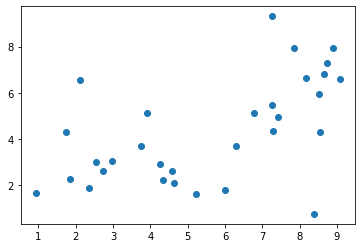

In [4]:
# The data behind https://xkcd.com/2048/
url = 'https://www.cl.cam.ac.uk/teaching/2021/DataSci/data/xkcd.csv'
xkcd = pandas.read_csv(url)
plt.scatter(xkcd.x, xkcd.y)
plt.show()

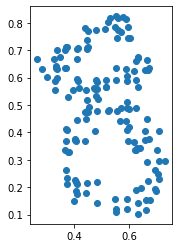

In [5]:
url = 'https://www.cl.cam.ac.uk/teaching/2021/DataSci/data/digit8.csv'
digit8 = pandas.read_csv(url)
plt.scatter(digit8.x, digit8.y)
plt.gca().set_aspect('equal')
plt.show()

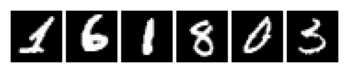

In [17]:
# PyTorch comes with a simple wrapper around the MNIST dataset.
# The dataset consists of a pair of (numpy_array, int) representing images and labels.
# We can pull out (image,label) pairs using e.g.
#   img,lbl = mnist[0]
#   img,lbl = next(iter(mnist))

mnist = torchvision.datasets.MNIST(
    root = 'pytorch-data/',    # where to put the files
    download = True,   # if files aren't here, download them
    train = True,      # whether to import the test or the train subset
    # PyTorch uses PyTorch tensors internally, not numpy arrays, so convert them.
    transform = torchvision.transforms.ToTensor()
)


# Very many PyTorch building blocks assume that the data comes in batches.
# The DataLoader converts the full mnist list [(img,lbl),...] into batches
#     [(img_batch,lbl_batch), ...]
# where each img_batch is an array with an extra dimension prepended.

mnist_batched = torch.utils.data.DataLoader(mnist, batch_size=100)

show = torch.stack([mnist[i][0] for i in [59289,28001,35508,43876,23627,14028]])
x = torchvision.utils.make_grid(show, nrow=6, pad_value=1)
plt.imshow(x.numpy().transpose((1,2,0))) # reshape from [channel,x,y] to [x,y,channel]
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# Regression, as a prediction task

Given the xkcd dataset consisting of pairs of real numbers $(x_i,y_i)$, fit a predictive model $y\approx f_\theta(x)$.

In [6]:
class Wiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(1,4),
            nn.LeakyReLU(),
            nn.Linear(4,20),
            nn.LeakyReLU(),
            nn.Linear(20,20),
            nn.LeakyReLU(),
            nn.Linear(20,1)
        )
    def forward(self, x, y):
        return torch.pow(y - self.f(x), 2)

In [7]:
x,y = torch.tensor(xkcd.x, dtype=torch.float)[:,None], torch.tensor(xkcd.y, dtype=torch.float)[:,None]

model = Wiggle()
epoch = 0

epoch=3800 loglik=2.564


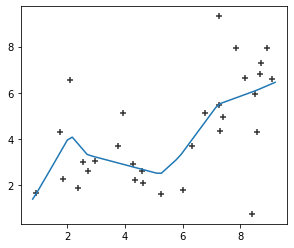

Interrupting ... stopped


In [17]:
optimizer = optim.Adam(model.parameters())

with Interruptable() as check_interrupted:
    while epoch < 10000:
        check_interrupted()
        optimizer.zero_grad()
        loss = torch.mean(model(x, y))
        loss.backward()
        optimizer.step()
        epoch += 1

        if epoch % 200 == 0:
            IPython.display.clear_output(wait=True)
            plt.scatter(x, y, color='black', marker='+', alpha=.8)
            with torch.no_grad():
                xnew = torch.linspace(.8,9.2,50)[:,None]
                plt.plot(xnew, model.f(xnew))
            plt.gca().set_aspect(.8)
            print(f'epoch={epoch} loglik={loss.item():.4}')
            plt.show()

# Regression, as a probability modelling task

Given the xkcd dataset consisting of pairs of real numbers $(x_i,y_i)$, fit a probability model
$Y\sim f_\theta(x)+N(0,\sigma^2)$.

In [10]:
class RWiggle(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(1,4),
            nn.LeakyReLU(),
            nn.Linear(4,20),
            nn.LeakyReLU(),
            nn.Linear(20,20),
            nn.LeakyReLU(),
            nn.Linear(20,1)
        )
        self.σ = nn.Parameter(torch.tensor(1.0))
    def forward(self, x, y):
        σ2 = torch.pow(self.σ, 2)
        return - 0.5*torch.log(2*np.pi*σ2) - torch.pow(y - self.f(x), 2) / (2*σ2)

In [11]:
x,y = torch.tensor(xkcd.x, dtype=torch.float)[:,None], torch.tensor(xkcd.y, dtype=torch.float)[:,None]

model2 = RWiggle()
# We might as well start with the fitted f function from the model above.
model2.f.load_state_dict(model.f.state_dict())
epoch = 0

In [12]:
# Pretty plot of the likelihood function

def plot_loglik(model2, ax):
    G = 100
    mx,Mx,my,My = 0,10,0,10
    xx,yy = np.meshgrid(np.linspace(mx,Mx,G), np.linspace(my,My,G))
    xx,yy = torch.tensor(xx, dtype=torch.float).reshape(-1,1), torch.tensor(yy, dtype=torch.float).reshape(-1,1)
    with torch.no_grad():
        p = torch.exp(model2(xx,yy)).detach().numpy()
    pp = p.reshape(G,G)

    b = plt.get_cmap('Blues')
    cols = np.row_stack([[[1,1,1,1]], b(np.linspace(0,1,9))])
    cols = [[1,1,1,1], b(.2), b(.4), b(.6), b(.7), b(.8), b(.9)]
    bluesw = matplotlib.colors.LinearSegmentedColormap.from_list('BluesW', cols)  
    
    ax.imshow(pp, extent=(mx,Mx,my,My), origin='lower', cmap=bluesw, alpha=.4)
    
    with torch.no_grad():
        xnew = torch.linspace(.8,9.2,50)[:,None]
        ax.plot(xnew, model2.f(xnew), color='steelblue')

epoch=5200 loglik=-1.82 σ=1.493
Interrupting ...

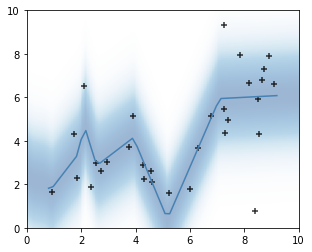

 stopped


In [18]:
optimizer = optim.Adam(model2.parameters())

with Interruptable() as check_interrupted:
    while epoch < 10000:
        check_interrupted()
        optimizer.zero_grad()
        loglik = torch.mean(model2(x, y))
        (-loglik).backward()
        optimizer.step()
        epoch += 1

        if epoch % 200 == 0:
            IPython.display.clear_output(wait=True)
            plt.scatter(x, y, color='black', marker='+', alpha=.8)
            plot_loglik(model2, plt.gca())
            plt.gca().set_aspect(.8)
            print(f'epoch={epoch} loglik={loglik.item():.4} σ={model2.σ.item():.4}')
            plt.show()

# MNIST image classifier

The MNIST dataset consists of pairs $(x_i,y_i)$ where each $x_i\in\mathbb{R}^{28\times28}$ is an image of a handwritten digit and $y_i\in\{0,1,\dots,9\}$ is its label. Fit the probability model
$$
Y_i \sim \operatorname{Categorical}\bigl(\operatorname{softmax}(\vec{f}(x_i;\theta))\bigr)
$$

In [19]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.f = nn.Sequential(       # input shape [B*1*28*28]
            nn.Conv2d(1, 32, 3, 1),   # -> [B*32*26*26]
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1),  # -> [B*64*24*24]
            nn.MaxPool2d(2),          # -> [B*64*12*12]
            nn.Dropout2d(0.25),
            nn.Flatten(1),            # -> [B*9216]
            nn.Linear(9216, 128),     # -> [B*128]
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(128, 10)        # -> [B*10]
        )

    # compute log likelihood for a batch of data
    def forward(self, x, y):          # x.shape [B*1*28*28], y.shape [B], output.shape [B]
        return - nn.functional.cross_entropy(self.f(x), y, reduction='none')

    # compute the class probabilities for a single image
    def classify(self, x):  # input: [1*28*28] array
        q = self.f(torch.as_tensor(x)[None,...])[0]
        return nn.functional.softmax(q, dim=0)

In [20]:
model = ImageClassifier()
# The enumerate_cycle utility function (at the top of this file) is an iterator
# that repeatedly cycles throught the dataset. So, if we interrupt the optimization
# part way through an epoch, and then restart, it will pick up where it left off.
ei_mnist = enumerate_cycle(mnist_batched, shuffle=False)

In [27]:
model.train(mode=True)
optimizer = optim.Adam(model.parameters())

with Interruptable() as check_interrupted:
    for (epoch,batch_num),(imgs,lbls) in ei_mnist:
        check_interrupted()
        optimizer.zero_grad()
        loglik = torch.mean(model(imgs, lbls))
        (-loglik).backward()
        optimizer.step()

        if batch_num % 25 == 0:
            IPython.display.clear_output(wait=True)
            print(f'epoch={epoch} batch={batch_num}/{len(mnist_batched)} loglik={loglik.item()}')

epoch=0 batch=525/12000 loglik=-0.5748506784439087
Interrupting ... stopped


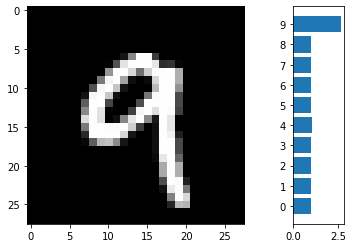

In [28]:
# Read off the classification of an image

model.train(mode=False)
img,_ = mnist[110]
logp = model.classify(img).detach().numpy()

fig,(ax1,ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios':[1,.2]})
ax1.imshow(img[0], cmap='gray')
ax2.barh(np.arange(10), np.exp(logp))
ax2.set_yticks(np.arange(10))
plt.show()

# Generative model

Train a generative model for a collection of points $x_1,x_2,\dots,x_n\in\mathbb{R}^2$. The model should have the form
$$
X \sim f(Z) + N(0,\sigma^2 I)
$$
where $f:[0,1]\to\mathbb{R}^2$ is a neural network to be trained, and $Z$ is a discretized $U[0,1]$ random variable taking evenly spaced values $\{z_1=0,\dots,z_m=1\}$.

In [31]:
class RCurve(nn.Module):
    def __init__(self, σ0=0.1, m=100):
        super().__init__()
        self.f = nn.Sequential(
            nn.Linear(1,4),
            nn.LeakyReLU(),
            nn.Linear(4,20),
            nn.LeakyReLU(),
            nn.Linear(20,20),
            nn.LeakyReLU(),
            nn.Linear(20,2)
            )
        self.σ = nn.Parameter(torch.tensor(σ0))
        self.z = torch.linspace(0,1,m)

    # log Pr(x)
    def forward(self, x):
        # x is a batch of 2d coordinates, i.e. shape batchsize*2
        μ = self.f(self.z.reshape(-1,1)).reshape(1,-1,2)
        x = x.reshape(-1,1,2)
        d = torch.linalg.norm(x - μ, dim=2)
        lik = torch.exp(- 0.5 * torch.pow(d/self.σ, 2))
        lik = torch.log(torch.mean(lik, dim=1)) - torch.log(2*np.pi*torch.pow(self.σ,2))
        return lik
    
    # Convenience function for reading off points on the path
    def loc(self, z):
        return self.f(torch.tensor(z, dtype=torch.float).reshape(-1,1)).detach()

In [40]:
X = torch.tensor([digit8.x, digit8.y]).transpose(0,1)
m = RCurve(σ0=0.03)
epoch = 0

epoch=1200 loglik=1.022 σ=0.1046


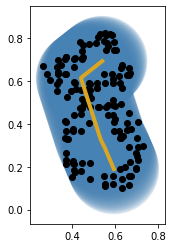

Interrupting ... stopped


In [43]:
optimizer = optim.Adam(m.parameters())

with Interruptable() as check_interrupted:
    while True:
        check_interrupted()
        optimizer.zero_grad()
        loglik = torch.mean(m(X))
        (-loglik).backward()
        optimizer.step()

        epoch += 1
        if epoch % 200 == 0:
            IPython.display.clear_output(wait=True)
            print(f'epoch={epoch} loglik={loglik.item():.4} σ={m.σ.item():.4}')
            z = np.linspace(0,1,101)
            pred = m.loc(z)
            σ = m.σ.item()
            circles = [plt.Circle(μ, 2*σ) for μ in pred]
            circles = matplotlib.collections.PatchCollection(circles, color='steelblue', alpha=.1, linewidth=None)
            plt.gca().add_collection(circles)
            plt.plot(pred[:,0], pred[:,1], color='goldenrod', linewidth=4)
            plt.scatter(X[:,0], X[:,1], c='black')
            plt.gca().set_aspect('equal')
            plt.show()

# Recurrent neural network

In [44]:
# Each name is a strings
url = "https://www.cl.cam.ac.uk/teaching/2021/DataSci/data/english_names.txt"
names = pandas.read_table(url, header=None, names=['X']).X.str.lower()
alphabet = list(set(''.join(names)))
alphabet_n = {c:i+1 for i,c in enumerate(alphabet)}
A = len(alphabet)+1

# Convert from strings to integer-coded (with 0 at beginning and end) then one-hot coding
names_n = [[0] + [alphabet_n[x] for x in name] + [0] for name in names]
names_n = [torch.tensor(n) for n in names_n]
names_oh = [nn.functional.one_hot(n, num_classes=A).float() for n in names_n]

names_oh,names_oh_holdout = names_oh[:3000], names_oh[3000:]

In [45]:
class RSeq(nn.Module):
    def __init__(self, H=50, L=2):
        super().__init__()
        self.rnn = nn.GRU(input_size=A, hidden_size=H, num_layers=L, dropout=.05)
        self.map = nn.Linear(self.rnn.hidden_size, A)
    
    def f(self, x, v=None):  # x.shape=m*b*A, v.shape=L*b*H
        assert x.shape[1]==1, "This code only works with batch_size=1"
        y,v = self.rnn(x, v) # y.shape=m*b*H, v.shape=L*b*H
        z = self.map(y)      # z.shape=m*b*A
        logp = nn.functional.log_softmax(z, dim=2) # logp.shape=m*b*A
        return v,logp
    
    def forward(self, x): # x.shape = (n+1)*b*A
        _,logp = self.f(x[:-1])      # logp.shape = n*b*A
        return torch.sum(logp * x[1:], dim=(0,2)) # shape = b
    
    def generate(self):
        is_training = self.training
        self.train(False)
        with torch.no_grad():
            res = ''
            x_n,v = 0,None
            while True:
                x_n = torch.tensor(x_n).reshape(1,1)
                x_oh = nn.functional.one_hot(x_n, num_classes=A).float()
                v,logp = model.f(x_oh, v)
                p = torch.exp(logp[0,0])
                x_n = np.random.choice(A, p=p.detach().numpy())
                if x_n == 0: break
                res += alphabet[x_n-1]
        self.train(is_training)
        return res

In [46]:
model = RSeq()
model.train(True)
optimizer = optim.Adam(model.parameters())
ei_names = enumerate_cycle(np.random.permutation(len(names_oh)))
loss_history = []

In [50]:
with Interruptable() as check_interrupted:
    for (epoch,i),j in ei_names:
        check_interrupted()
        optimizer.zero_grad()
        loglik = model(names_oh[j][:,None,:])
        (-loglik).backward()
        optimizer.step()

        if i % 20 == 0:
            IPython.display.clear_output(wait=True)
            with torch.no_grad():
                eval_loglik = np.mean([model(n[:,None,:]).item() for n in names_oh_holdout])
            print(f'epoch={epoch} item={i}/{len(names_oh)} loglik.e={eval_loglik:.4} loglik({names[j]})={loglik.item():.4} name={model.generate()}')
            loss_history.append((epoch+i/len(names_oh), loglik.item(), eval_loglik))

Interrupting ...epoch=0 item=440/3000 loglik.e=-21.37 loglik(gibbs)=-18.85 name=brejusnn
 stopped


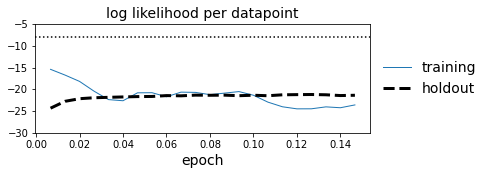

In [51]:
# Simple plot of the training loss

df = pandas.DataFrame.from_records(loss_history, columns=['epoch','loglik_tr','loglik_eval'])
fig,ax = plt.subplots(figsize=(6,2))
ax.plot(df.epoch, df.loglik_tr.ewm(com=8).mean(), linewidth=1, label='training')
ax.plot(df.epoch, df.loglik_eval, linewidth=3, linestyle='dashed', color='black', label='holdout')
ax.axhline(y=np.log(1/len(names_oh)), color='black', linestyle=':')

ax.set_ylim([-30,-5])
ax.set_title('log likelihood per datapoint', fontsize=14)
ax.set_xlabel('epoch', fontsize=14)
plt.legend(bbox_to_anchor=(1,.5), loc='center left', frameon=False, fontsize=14)
plt.show()

# Probabilistic autoencoder

Here is a generative model for MNIST digits:
```python
def rx():
    f = ... # a neural network
    z = np.random.normal(size=d) # a length-d vector of real values
    p = f(z)                     # a 1×28×28 matrix of [0,1] values
    return np.random.binom(1,p)  # returns a 1×28×28 matrix of {0,1} values
```
We can train it using an autoencoder, with a Gaussian encoder. 
Let the dataset be $x_1,\dots,x_n$.
The training objective for an autoencoder is to choose neural network parameters so as to maximize
$$
\mathcal{L}_{\text{lb}} = \sum_i \Bigl\{ \Bigl[ \mathbb{E}\log\operatorname{Pr}_X(x_i|\tilde{Z})\Bigr] - \operatorname{KL}\bigl(\operatorname{Pr}_{\tilde{Z}}\|\operatorname{Pr}_Z\bigr)\Bigr\}
$$
where $\tilde{Z}=\mu+\sigma N(0,I_d)$, and where $\mu\in\mathbb{R}^d$ and $\sigma\in\mathbb{R}_{\geq0}^d$ are the outputs of an encoder neural network $g(x_i)$.

In [7]:
class BernoulliImageGenerator(nn.Module):
    def __init__(self, d=4):
        super().__init__()
        self.d = d
        self.f = nn.Sequential(
            nn.Linear(d, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 1728),
            nn.LeakyReLU(),
            nn.Unflatten(1, (12,12,12)), # -> B×12×12×12
            nn.Conv2d(12, 36, 3, 1),     # -> [B×36×10×10]
            nn.LeakyReLU(),
            nn.Flatten(1),               # -> [B×3600]
            nn.Unflatten(1, (4,30,30)),  # -> [B×4×30×30]
            nn.Conv2d(4, 4, 3, 1),       # -> [B×4×28×28]
            nn.LeakyReLU(),
            nn.Conv2d(4, 1, 1, 1),       # -> [B×1×28×28]
            nn.Sigmoid()
        )

    def forward(self, z):
        return self.f(z)

    def loglik(self, x, z):
        xr = self(z)
        return (x*torch.log(xr) + (1-x)*torch.log(1-xr)).sum((1,2,3))
    
class GaussianEncoder(nn.Module):
    def __init__(self, decoder):
        super().__init__()
        self.d = decoder.d
        self.f = decoder
        self.g = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, 1),
            nn.MaxPool2d(2),
            nn.Flatten(1),
            nn.Linear(9216, 128),
            nn.LeakyReLU(),
            nn.Linear(128, self.d*2)
        )

    def forward(self, x):
        μτ = self.g(x)
        μ,τ = μτ[:,:self.d], μτ[:,self.d:]
        return μ, torch.exp(τ/2)

    def loglik_lb(self, x):
        μ,σ = self(x)
        kl = 0.5 * (μ**2 + σ**2 - torch.log(σ**2) - 1).sum(1)
        ε = torch.randn_like(σ)
        ll = self.f.loglik(x, z=μ+σ*ε)
        return ll - kl

In [18]:
model = GaussianEncoder(BernoulliImageGenerator(d=20))
ei_mnist = enumerate_cycle(mnist_batched, shuffle=False)

In [23]:
optimizer = optim.Adam(model.parameters())

with Interruptable() as check_interrupted:
    for (epoch,batch_num),(imgs,lbls) in ei_mnist:
        check_interrupted()
        optimizer.zero_grad()
        loglik_lb = torch.mean(model.loglik_lb(imgs))
        (-loglik_lb).backward()
        optimizer.step()

        if batch_num % 25 == 0:
            IPython.display.clear_output(wait=True)
            print(f'epoch={epoch} batch={batch_num}/{len(mnist_batched)} loglik={loglik_lb.item()}')

epoch=4 batch=525/600 loglik=-106.641357421875
Interrupting ... stopped


**Reconstruction.** Strictly speaking, when we feed an image $x$ into the encoder we get out a random variable $\tilde{Z}\sim N(\mu(x),\sigma^2(x))$; and when we feed a latent representation $z$ into the generator we get out a random variable $X\sim\operatorname{Binom}(1,f(z))$. The following code ignores this probabilistic nature: it just reads off $\mu(x)$ from the generator, and it shows $f(\mu)$.

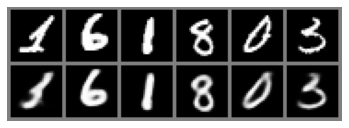

In [24]:
x = torch.stack([mnist[i][0] for i in [59289,28001,35508,43876,23627,14028]])
with torch.no_grad():
    μ,_ = model(x)
    xr = model.f(μ)

imgs = torch.cat([x,xr], 0)
imgs = torchvision.utils.make_grid(imgs, nrow=6, pad_value=.5)
plt.imshow(imgs.numpy().transpose((1,2,0)))
plt.axis('off')
plt.show()

**Generation.** These plots show $f(Z)$ for random values of $Z$. One could also show the actual random image $X\sim\operatorname{Binom}(1,f(Z))$.

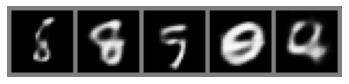

In [27]:
with torch.no_grad():
    z = torch.normal(mean=0.0, std=1.0, size=(5,model.f.d))
    rx = model.f(z)

imgs = torchvision.utils.make_grid(rx, nrow=5, pad_value=.5)
plt.imshow(imgs.numpy().transpose((1,2,0)))
plt.axis('off')
plt.show()